TODO: simplify this experiment. Can I tell apart 0, 1, 2 cnots happening at the same time?

# About the experiment
Aim: Determine if we can differentiate between single and multiple CNOTs being applied at the same time. Bonus if we can determine which CNOT is being applied exactly.
Confirm if CNOTs cause more phase flips or amplitude flips.

To find out we take a 3 qubit chain for the victim qubits. That means there are 2 links and each link can act both ways. So the link can be (OFF, +, -).


1. No CNOTs
2. 1 CNOT - 4 possibilities
3. 2 CNOTs - 8 possibilities
    1. (+, +) - 2 possibilites
    2. (+, -) - 2 possibility
    3. (-, +) - 2 possibilites
    4. (-, -) - 2 possibilites

Therefore, total 13 possible circuits with a max of 2 CNOTs.


Backend: IBM Lagos.

On this backend we can choose 6 such 3 qubit chains.

Since we want to be able to detect upto two CNOTs we shall snoop for about 2 CNOT durations.

<!-- Victim CNOTs applied: [ (3, 5) ] \
Attacker Qubits: (0, 1, 2, 4, 6) -->

# Imports

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.transpiler import CouplingMap
from common import attacker

# Parameters

In [2]:
num_of_atk_qubits = 4
num_of_vic_qubits = 3
reps = 3
delays = [0] + [2**i * 160 for i in range(4)] + [i for i in range(1920, 5600, 640)]

In [3]:
delays

[0, 160, 320, 640, 1280, 1920, 2560, 3200, 3840, 4480, 5120]

# Attack Circuit

In [4]:
atk_qregs = QuantumRegister(num_of_atk_qubits, name='atk')
snooping_delay_dt = Parameter('snoop_delay')

cregs_list = [ClassicalRegister(num_of_atk_qubits, name='atk_rep_{}'.format(i)) for i in range(reps)]

## Phase flip snooping circuit

In [5]:
phase_flip_atk_qc = QuantumCircuit(atk_qregs, *cregs_list)

for i in range(reps - 1):
    phase_flip_atk_qc.h(atk_qregs)
    phase_flip_atk_qc.delay(snooping_delay_dt, atk_qregs)
    phase_flip_atk_qc.h(atk_qregs)
    attacker.measure_and_conditional_reset(phase_flip_atk_qc, atk_qregs, cregs_list[i])
    phase_flip_atk_qc.barrier()
    # atk_qc.append(measure_all_conditional_reset_qc, atk_qregs, cregs_list[i])
phase_flip_atk_qc.h(atk_qregs)
phase_flip_atk_qc.delay(snooping_delay_dt, atk_qregs)
phase_flip_atk_qc.h(atk_qregs)
phase_flip_atk_qc.measure(atk_qregs, cregs_list[-1])

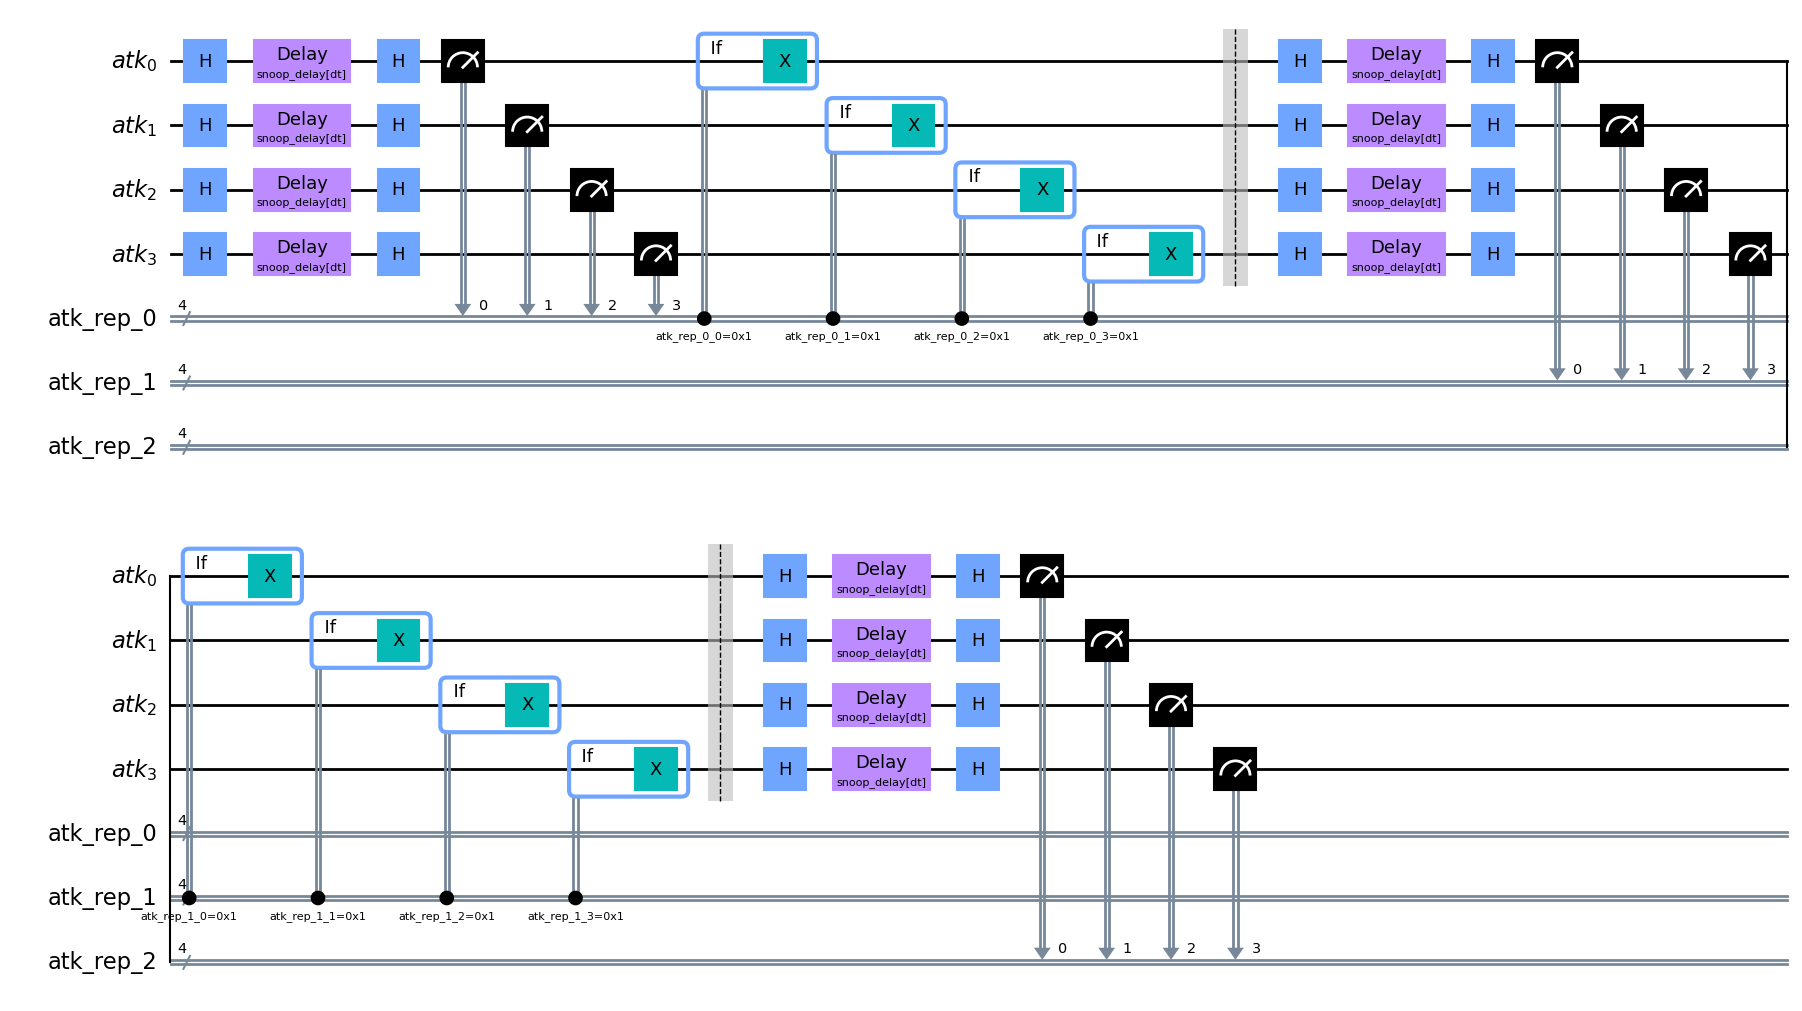

In [6]:
phase_flip_atk_qc.draw('mpl')

## Amplitude Flip snooping circuit

In [7]:
amp_flip_atk_qc = QuantumCircuit(atk_qregs, *cregs_list)

for i in range(reps - 1):
    amp_flip_atk_qc.delay(snooping_delay_dt, atk_qregs)
    attacker.measure_and_conditional_reset(amp_flip_atk_qc, atk_qregs, cregs_list[i])
    amp_flip_atk_qc.barrier()
amp_flip_atk_qc.delay(snooping_delay_dt, atk_qregs)
amp_flip_atk_qc.measure(atk_qregs, cregs_list[-1])

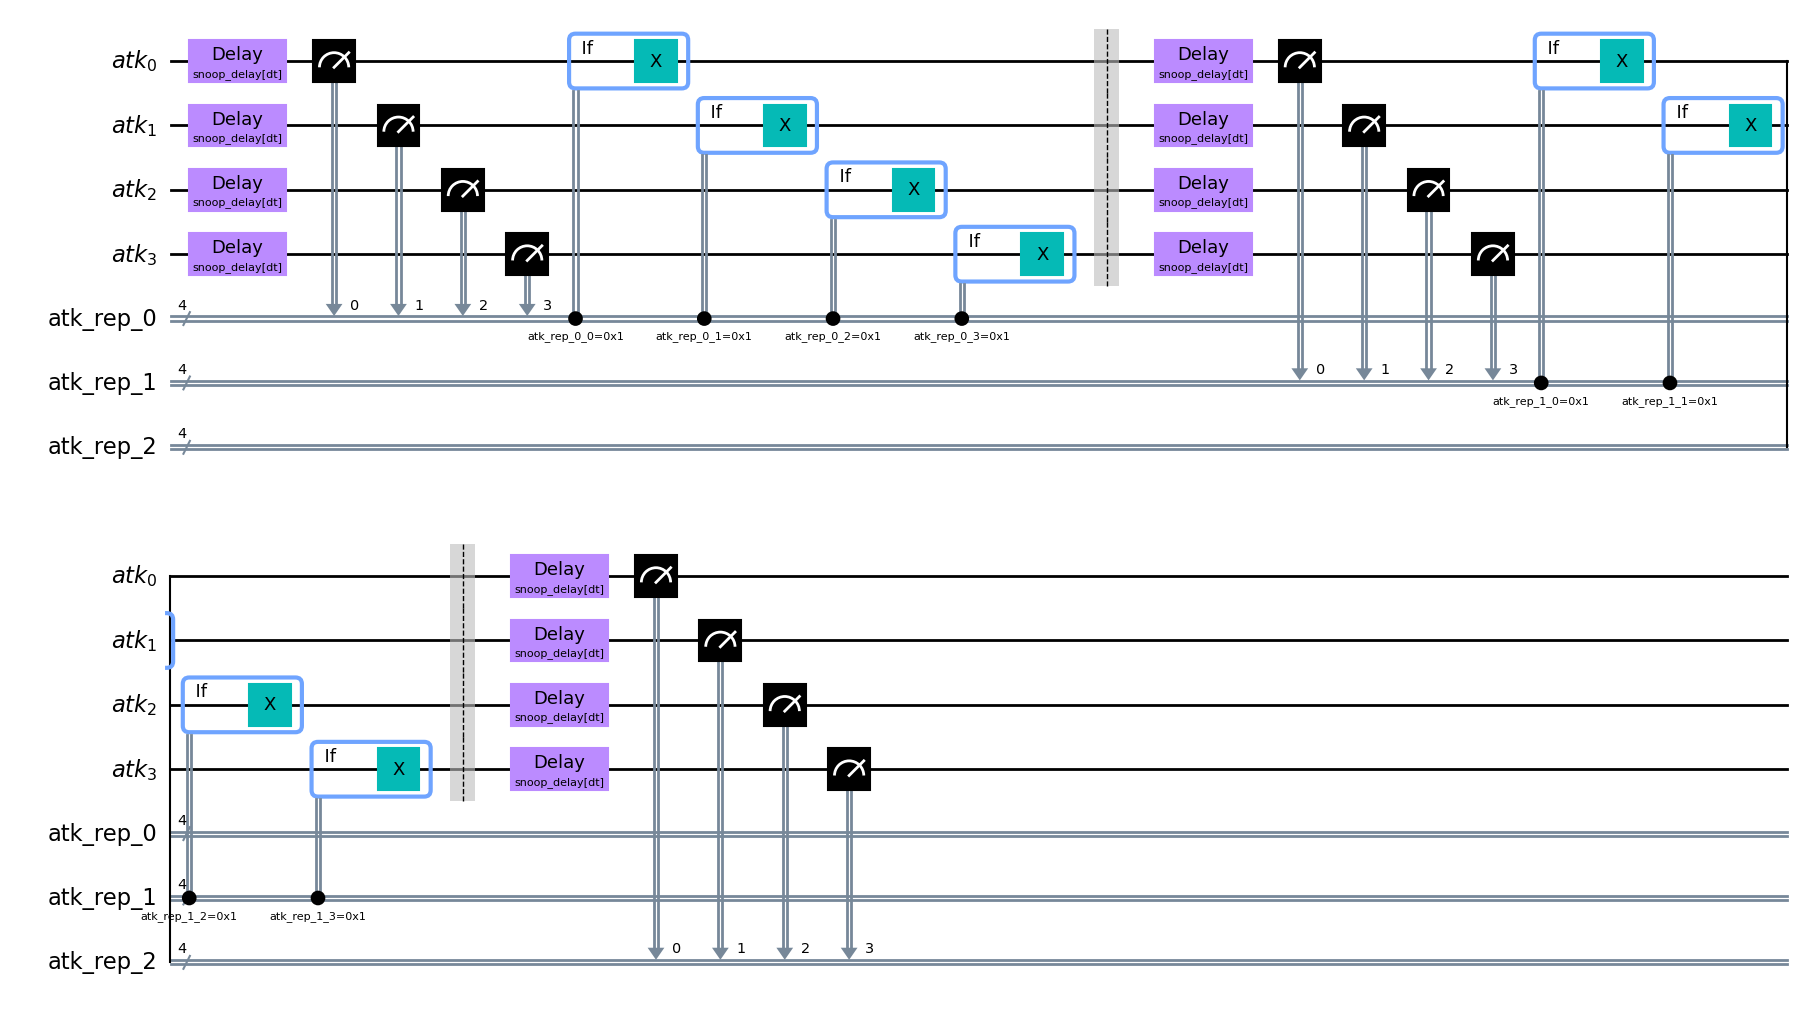

In [8]:
amp_flip_atk_qc.draw('mpl')

# Victim Circuits

## Create Coupling Map for 3 qubit chain

In [9]:
victim_cm = CouplingMap([
    [0, 1],
    [1, 2]
])

victim_cm.make_symmetric()

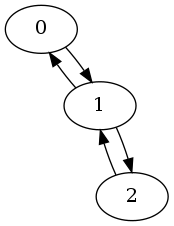

In [10]:
display(victim_cm.draw().convert('RGB'))

## Create all possible victim circuits

In [14]:
list(victim_cm.get_edges())

[(0, 1), (1, 2), (1, 0), (2, 1)]

In [20]:
list(victim_cm.neighbors(1))

[2, 0]

In [22]:
from itertools import permutations

In [26]:
list(permutations(victim_cm.get_edges(), 2))

[((0, 1), (1, 2)),
 ((0, 1), (1, 0)),
 ((0, 1), (2, 1)),
 ((1, 2), (0, 1)),
 ((1, 2), (1, 0)),
 ((1, 2), (2, 1)),
 ((1, 0), (0, 1)),
 ((1, 0), (1, 2)),
 ((1, 0), (2, 1)),
 ((2, 1), (0, 1)),
 ((2, 1), (1, 2)),
 ((2, 1), (1, 0))]

In [11]:
# vic_qregs = QuantumRegister(num_of_vic_qubits, name='vic')

# Full Circuits

In [12]:
# qc = QuantumCircuit(3)
# qc.cx(1, 0)
# qc.cx(1, 2)
# qc.draw('mpl')